In [ ]:
# STEP 2: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
!pip install grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 57.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 120.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 65.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 44.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 20.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 104.7 MB/

In [ ]:
# Step 1: Import Required Libraries
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from PIL import Image
import timm
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

# Step 2: Define ResNeSt-101 Model (As it was trained)
class ResNeSt101Model(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.base_model = timm.create_model('resnest101e', pretrained=False, num_classes=0, global_pool='avg')
        self.meta_fc = torch.nn.Sequential(
            torch.nn.Linear(3, 32),
            torch.nn.BatchNorm1d(32),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.3)
        )
        self.head = torch.nn.Sequential(
            torch.nn.Linear(self.base_model.num_features + 32, 256),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.5),
            torch.nn.Linear(256, 1)
        )

    def forward(self, x, meta):
        x = self.base_model(x)  # Image feature extraction
        meta = self.meta_fc(meta)  # Metadata processing
        x = torch.cat([x, meta], dim=1)  # Merge features
        return self.head(x).squeeze()

# Step 3: Load Trained Model (Ensure No Retraining Required)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ResNeSt101Model().to(device)
model.load_state_dict(torch.load('/content/drive/MyDrive/PW2/models/ResNeSt101_BestModel_combined_improved.pth', map_location=device))
model.eval()

# Step 4: Create a Grad-CAM Wrapper (Bypassing Metadata)
class ResNeSt101GradCAMWrapper(torch.nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.base_model = model.base_model  # Use only the CNN part

    def forward(self, x):
        """Forward function that only passes image input for Grad-CAM"""
        return self.base_model(x)  # Outputs feature maps for Grad-CAM

# Instantiate Grad-CAM Wrapper Model
gradcam_model = ResNeSt101GradCAMWrapper(model)

# Step 5: Select the Last Convolutional Layer for Grad-CAM
target_layer = gradcam_model.base_model.layer4[-1]  # Last convolutional layer

# Initialize Grad-CAM
cam = GradCAM(model=gradcam_model, target_layers=[target_layer])

# Step 6: Define Image Preprocessing Function
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Ensure consistent size
    transforms.ToTensor()
])

def preprocess_image(image_path):
    img = Image.open(image_path).convert("RGB")
    img = img.resize((256, 256))  # Resize to match model input
    img_tensor = transform(img).unsqueeze(0).to(device)
    return img, img_tensor


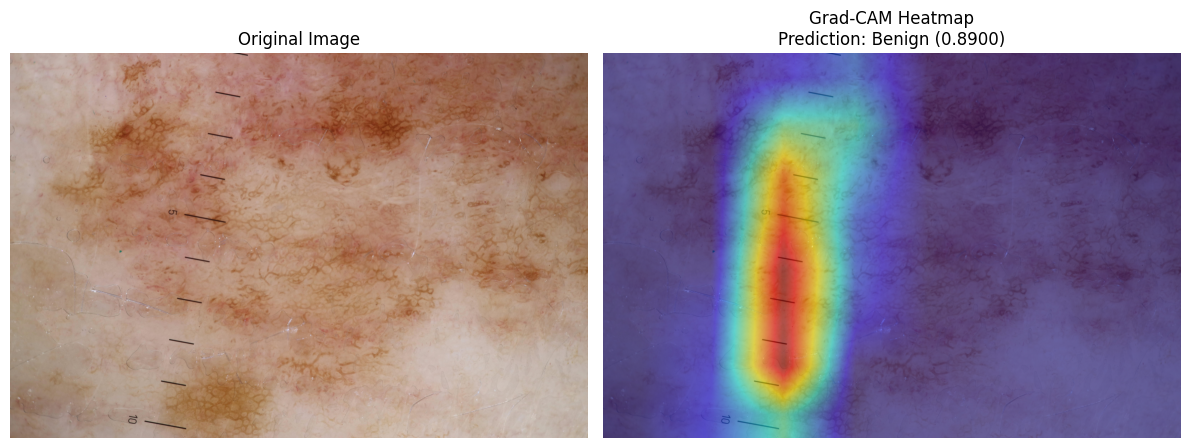

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import cv2
from torchvision import transforms
from PIL import Image
import joblib

# Load test dataset
test_df = joblib.load('/content/drive/MyDrive/PW2/test_dataset.pkl')

# Find the first malignant case
malignant_row = test_df[test_df['benign_malignant'] == 'benign'].iloc[106]
image_path = malignant_row['image_path']

# Load and preprocess image
def preprocess_image(image_path):
    img = Image.open(image_path).convert("RGB")
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
    ])
    img_tensor = transform(img).unsqueeze(0).to(device)
    return img, img_tensor

original_img, img_tensor = preprocess_image(image_path)

# Dummy metadata (adjust if you're using real metadata)
meta_dummy = torch.zeros((1, 3)).to(device)

# Generate Grad-CAM
grayscale_cam = cam(input_tensor=img_tensor)[0]

# Convert original image to numpy array and normalize
original_img_np = np.array(original_img) / 255.0

# Resize CAM to match image size
grayscale_cam_resized = cv2.resize(grayscale_cam, (original_img_np.shape[1], original_img_np.shape[0]))

# Overlay
visualization = show_cam_on_image(original_img_np, grayscale_cam_resized, use_rgb=True)

# Get model prediction
with torch.no_grad():
    output = torch.sigmoid(model(img_tensor, meta_dummy)).cpu().item()

prediction_label = "Malignant" if output >= 0.5 else "Benign"
confidence_score = output if output >= 0.5 else 1 - output

# Plot
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(original_img)
plt.axis("off")
plt.title("Original Image")

plt.subplot(1, 2, 2)
plt.imshow(visualization)
plt.axis("off")
plt.title(f"Grad-CAM Heatmap\nPrediction: {prediction_label} ({confidence_score:.4f})")

plt.tight_layout()
plt.show()


In [ ]:
!pip install gradio --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.9/46.9 MB 54.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.2/322.2 kB 23.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 123.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 5.6 MB/s eta 0:00:00


In [ ]:
import gradio as gr
import numpy as np
from PIL import Image
import torch
import cv2

preprocess_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

def predict_with_gradcam(uploaded_img):
    # Preprocess
    img_tensor = preprocess_transform(uploaded_img).unsqueeze(0).to(device)
    meta_dummy = torch.zeros((1, 3)).to(device)

    # Prediction
    with torch.no_grad():
        output = torch.sigmoid(model(img_tensor, meta_dummy)).cpu().item()
    label = "Malignant" if output >= 0.5 else "Benign"
    confidence = output if output >= 0.5 else 1 - output

    # Grad-CAM
    grayscale_cam = cam(input_tensor=img_tensor)[0]
    grayscale_cam_resized = cv2.resize(grayscale_cam, (uploaded_img.size[0], uploaded_img.size[1]))
    image_np = np.array(uploaded_img).astype(np.float32) / 255.0
    visualization = show_cam_on_image(image_np, grayscale_cam_resized, use_rgb=True)

    return label + f" ({confidence:.2f})", Image.fromarray(visualization)

# Gradio UI
gr.Interface(
    fn=predict_with_gradcam,
    inputs=gr.Image(type="pil"),
    outputs=["text", "image"],
    title="Skin Lesion Diagnosis with Grad-CAM",
    description="Upload a skin lesion image to see model prediction and heatmap"
).launch(share=True, inbrowser=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://148bf0c6c87b3af19f.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
import torch
import numpy as np
import cv2
from tqdm import tqdm
from torchvision import transforms
from PIL import Image

# Preprocess image with early resizing
def preprocess_image(image_path):
    img = Image.open(image_path).convert("RGB")
    transform = transforms.Compose([
        transforms.Resize((256, 256)),  # Resize early to reduce memory load
        transforms.ToTensor(),
    ])
    img_tensor = transform(img).unsqueeze(0)  # Add batch dimension
    return img, img_tensor

# Grad-CAM evaluation function
def evaluate_gradcam_metrics(model, cam, df, device):
    model.eval()

    avg_drop_scores = []
    increase_conf_scores = []
    base_confidences = []
    cam_confidences = []

    for idx in tqdm(range(len(df))):
        row = df.iloc[idx]
        image_path = row['image_path']

        # Preprocess image
        original_img, img_tensor = preprocess_image(image_path)
        img_tensor = img_tensor.to(device)
        meta_dummy = torch.zeros((1, 3)).to(device)

        # Base confidence
        with torch.no_grad():
            base_conf = torch.sigmoid(model(img_tensor, meta_dummy)).cpu().item()

        # Grad-CAM
        grayscale_cam = cam(input_tensor=img_tensor)[0]
        grayscale_cam_resized = cv2.resize(grayscale_cam, (original_img.size[0], original_img.size[1]))
        mask = (grayscale_cam_resized - grayscale_cam_resized.min()) / (np.ptp(grayscale_cam_resized) + 1e-8)
        binary_mask = (mask > 0.5).astype(np.float32)

        # Apply mask
        img_np = np.array(original_img).astype(np.float32) / 255.0
        preserved_img = img_np * binary_mask[..., None]
        preserved_tensor = transforms.ToTensor()(Image.fromarray((preserved_img * 255).astype(np.uint8))).unsqueeze(0).to(device)
        preserved_tensor = transforms.Resize((256, 256))(preserved_tensor)

        with torch.no_grad():
            cam_conf = torch.sigmoid(model(preserved_tensor, meta_dummy)).cpu().item()
            torch.cuda.empty_cache()  # Prevent memory buildup

        # Store results
        base_confidences.append(base_conf)
        cam_confidences.append(cam_conf)

        avg_drop = max(0, (base_conf - cam_conf) / (base_conf + 1e-8)) * 100
        confidence_increase = min(max(0, (cam_conf - base_conf) / max(base_conf, 1e-3)) * 100, 100)

        avg_drop_scores.append(avg_drop)
        increase_conf_scores.append(confidence_increase)

    # Summary
    print("\n🎯 Final Grad-CAM Evaluation Summary:")
    print(f"🔹 Avg Base Confidence: {np.mean(base_confidences):.4f}")
    print(f"🔸 Avg CAM Confidence: {np.mean(cam_confidences):.4f}")
    print(f"📉 Avg Drop: {np.mean(avg_drop_scores):.2f}%")
    print(f"📈 Confidence Increase: {np.mean(increase_conf_scores):.2f}%")

    return {
        "avg_base_conf": np.mean(base_confidences),
        "avg_cam_conf": np.mean(cam_confidences),
        "avg_drop": np.mean(avg_drop_scores),
        "conf_increase": np.mean(increase_conf_scores)
    }

# Run the evaluation
evaluate_gradcam_metrics(model, cam, test_df, device)


100%|██████████| 5690/5690 [2:41:58<00:00,  1.71s/it]


🎯 Final Grad-CAM Evaluation Summary:
🔹 Avg Base Confidence: 0.2007
🔸 Avg CAM Confidence: 0.1500
📉 Avg Drop: 21.24%
📈 Confidence Increase: 53.78%


{'avg_base_conf': np.float64(0.20068439710015137),
 'avg_cam_conf': np.float64(0.15002093101734357),
 'avg_drop': np.float64(21.244244895359),
 'conf_increase': np.float64(53.780916681554174)}